# 实验三 机械臂关节运动学实验


## 编码实现

1.  **导入相关的库**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from math import cos, sin, pi
from mpl_toolkits.mplot3d import Axes3D

In [7]:
# 下载字体
!wget https://github.com/wkwbk/ipynb/raw/main/%E6%95%B0%E6%8D%AE%E9%87%87%E9%9B%86/SimHei.ttf

--2025-04-20 06:33:57--  https://github.com/wkwbk/ipynb/raw/main/%E6%95%B0%E6%8D%AE%E9%87%87%E9%9B%86/SimHei.ttf
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wkwbk/ipynb/main/%E6%95%B0%E6%8D%AE%E9%87%87%E9%9B%86/SimHei.ttf [following]
--2025-04-20 06:33:57--  https://raw.githubusercontent.com/wkwbk/ipynb/main/%E6%95%B0%E6%8D%AE%E9%87%87%E9%9B%86/SimHei.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9751960 (9.3M) [application/octet-stream]
Saving to: ‘SimHei.ttf’

SimHei.ttf          100%[===================>]   9.30M  --.-KB/s    in 0.1s    

2025-04-20 06:33:58 (78.2 MB/s) - ‘SimHei.tt

In [10]:
# 添加字体文件
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

fm.fontManager.addfont('./SimHei.ttf')
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False

2.  **运动学计算模块**

In [2]:
class RobotArmKinematics:
    """机械臂运动学计算类"""
    def __init__(self):
        # UR5机械臂DH参数 (α, a, d, θ)
        self.dh_params = [
            (pi/2, 0, 0.0892, 0),    # Joint1
            (0, -0.425, 0, 0),       # Joint2
            (0, -0.392, 0, 0),       # Joint3
            (pi/2, 0, 0.109, 0),     # Joint4
            (-pi/2, 0, 0.0946, 0),   # Joint5
            (0, 0, 0.0823, 0) ]       # Joint6

    def dh_matrix(self, alpha, a, d, theta):
        """计算单关节变换矩阵"""
        return np.array([
            [cos(theta), -sin(theta)*cos(alpha), sin(theta)*sin(alpha), a*cos(theta)],
            [sin(theta), cos(theta)*cos(alpha), -cos(theta)*sin(alpha), a*sin(theta)],
            [0, sin(alpha), cos(alpha), d],
            [0, 0, 0, 1]])

    def forward_kinematics(self, joint_angles):
        """正运动学计算"""
        T = np.eye(4)
        for i, (alpha, a, d, _) in enumerate(self.dh_params):
            theta = joint_angles[i]
            T = T @ self.dh_matrix(alpha, a, d, theta)
        return T

    def inverse_kinematics(self, target_pose, init_angles=None, max_iter=100):
        """数值逆运动学解算"""
        if init_angles is None:
            init_angles = np.zeros(6)
        q = init_angles.copy()
        for _ in range(max_iter):
            T = self.forward_kinematics(q)
            # 位置误差
            error_pos = target_pose[:3,3] - T[:3,3]
            # 姿态误差
            error_ori = 0.5*(np.cross(T[:3,0], target_pose[:3,0]) +
                             np.cross(T[:3,1], target_pose[:3,1]) +
                             np.cross(T[:3,2], target_pose[:3,2]))

            # Jacobian矩阵计算
            J = self.compute_jacobian(q)
            # 阻尼最小二乘解
            dq = np.linalg.pinv(J) @ np.concatenate([error_pos, error_ori])
            q += dq * 0.1
            # 收敛判断
            if np.linalg.norm(error_pos) < 1e-4 and np.linalg.norm(error_ori) < 1e-4:
                break
        return q

    def compute_jacobian(self, joint_angles):
        """计算几何Jacobian矩阵"""
        J = np.zeros((6, 6))
        T = np.eye(4)
        z_vectors = []
        p_vectors = []
        # 正向计算各关节的z轴和位置
        for i, (alpha, a, d, _) in enumerate(self.dh_params):
            theta = joint_angles[i]
            T = T @ self.dh_matrix(alpha, a, d, theta)
            z_vectors.append(T[:3, 2])
            p_vectors.append(T[:3, 3])
        # 末端执行器位置
        pe = p_vectors[-1]
        # 构造Jacobian矩阵
        for i in range(6):
            # 旋转部分
            J[:3, i] = np.cross(z_vectors[i], pe - p_vectors[i])
            # 平移部分
            J[3:, i] = z_vectors[i]
        return J

3.  **轨迹规划模块**

In [3]:
class ObstacleAvoidancePlanner:
    """避障轨迹规划器"""
    def __init__(self):
        self.repulsive_gain = 0.3  # 排斥力系数
        self.attractive_gain = 0.7  # 吸引力系数
        self.safe_distance = 0.3  # 安全距离

    def plan_path(self, start, goal, obstacles):
        """生成避障路径"""
        path = [start]
        current = np.array(start)
        step_size = 0.01
        max_steps = 1000
        for _ in range(max_steps):
            # 计算到目标的距离
            to_goal = goal - current
            dist_to_goal = np.linalg.norm(to_goal)
            if dist_to_goal < step_size:
                path.append(goal)
                break
            # 标准化方向向量
            direction = to_goal / dist_to_goal
            # 计算障碍物排斥力
            repulsive = np.zeros(3)
            for obs in obstacles:
                to_obs = current - obs['position']
                dist_to_obs = np.linalg.norm(to_obs)
                if dist_to_obs < obs['radius'] + self.safe_distance:
                    repulsive += (1/dist_to_obs - 1/(obs['radius'] + self.safe_distance)) * \
                        (to_obs / dist_to_obs**3)
            # 合成运动方向
            move_dir = self.attractive_gain * direction + self.repulsive_gain * repulsive
            if np.linalg.norm(move_dir) > 0:
                move_dir = move_dir / np.linalg.norm(move_dir)
            # 更新位置
            current = current + move_dir * step_size
            path.append(current.copy())
        return np.array(path)

class BSplineTrajectory:
    """B样条轨迹生成器"""
    def generate(self, waypoints, num_points=100, degree=3):
        """生成平滑B样条轨迹"""
        t = np.linspace(0, 1, len(waypoints))  # 参数化处理
        t_new = np.linspace(0, 1, num_points)
        # 为每维坐标生成B样条
        splines = []
        for dim in range(3):  # x, y, z三个维度
            spl = BSpline(t, waypoints[:, dim], k=degree)
            splines.append(spl)
        # 生成轨迹点
        trajectory = np.vstack([spline(t_new) for spline in splines]).T
        return trajectory

4.  **运动控制模块**

In [4]:
class JointPIDController:
    """关节PID控制器"""
    def __init__(self, kp=1.0, ki=0.1, kd=0.01):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.prev_error = np.zeros(6)
        self.integral = np.zeros(6)
        self.windup_limit = 1.0  # 积分限幅

    def compute(self, q_desired, q_actual, dt):
        """计算控制输出"""
        error = q_desired - q_actual
        # 积分项
        self.integral += error * dt
        self.integral = np.clip(self.integral, -self.windup_limit, self.windup_limit)
        # 微分项
        derivative = (error - self.prev_error) / dt
        # PID输出
        output = self.kp * error + self.ki * self.integral + self.kd * derivative
        self.prev_error = error
        return output


def visualize_trajectory(trajectory, obstacles):
    """3D轨迹可视化"""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    # 绘制轨迹
    ax.plot(trajectory[:, 0], trajectory[:, 1], trajectory[:, 2],
            'b-', linewidth=2, label='Planned Trajectory')
    # 绘制障碍物
    for obs in obstacles:
        u = np.linspace(0, 2 * np.pi, 30)
        v = np.linspace(0, np.pi, 30)
        x = obs['radius'] * np.outer(np.cos(u), np.sin(v)) + obs['position'][0]
        y = obs['radius'] * np.outer(np.sin(u), np.sin(v)) + obs['position'][1]
        z = obs['radius'] * np.outer(np.ones(np.size(u)), np.cos(v)) + obs['position'][2]
        ax.plot_surface(x, y, z, color='r', alpha=0.5)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_zlabel('Z (m)')
    ax.set_title('机器人臂避障轨迹')
    ax.legend()
    plt.show()


5.  **主程序**

开始避障路径规划....
正在为所有轨迹点计算逆运动学...
模拟关节控制...
Step 0: 最大误差 12.9599 rad
正在可视化结果...


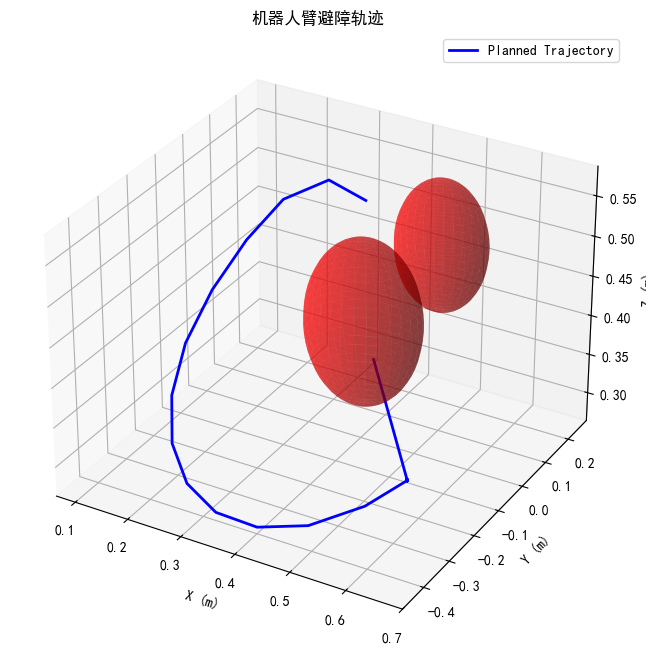

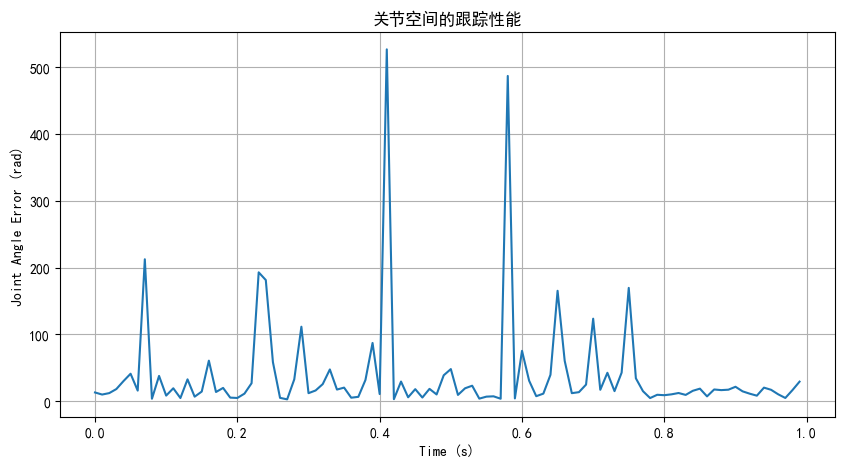


=== 控制性能总结===
最终误差: 29.166571 弧度
最大误差: 526.686064 弧度
平均误差: 39.501019 弧度
轨迹规划和执行完成！！


In [11]:
def main():
    # 初始化各模块
    arm = RobotArmKinematics()
    planner = ObstacleAvoidancePlanner()
    traj_gen = BSplineTrajectory()
    pid = JointPIDController(kp=1.2, ki=0.2, kd=0.05)

    # 定义任务场景
    start_pos = np.array([0.3, 0.2, 0.5])  # 起始位置
    goal_pos = np.array([0.6, -0.3, 0.4])  # 目标位置

    # 定义障碍物 (位置和半径)
    obstacles = [{'position': np.array([0.45, -0.1, 0.45]), 'radius': 0.1},
                 {'position': np.array([0.5, 0.1, 0.5]), 'radius': 0.08}]

    print("开始避障路径规划....")
    # 1. 路径规划
    path = planner.plan_path(start_pos, goal_pos, obstacles)

    # 2. 轨迹生成
    cartesian_traj = traj_gen.generate(path, num_points=100)

    print("正在为所有轨迹点计算逆运动学...")
    # 3. 逆运动学解算
    joint_traj = []
    for point in cartesian_traj:
        # 构造目标位姿 (默认朝向)
        target_pose = np.eye(4)
        target_pose[:3, 3] = point
        target_pose[:3, :3] = np.eye(3)  # 假设末端保持默认朝向

        # 逆运动学计算
        q = arm.inverse_kinematics(target_pose)
        joint_traj.append(q)

    print("模拟关节控制...")
    # 4. PID控制模拟
    actual_angles = np.zeros(6)
    errors = []
    time_steps = []
    for i, q_des in enumerate(joint_traj):
        # PID控制计算
        torque = pid.compute(q_des, actual_angles, dt=0.01)
        # 简单模拟动力学 (假设单位惯量)
        actual_angles += torque * 0.01
        # 记录误差
        errors.append(np.linalg.norm(q_des - actual_angles))
        time_steps.append(i * 0.01)

        if i % 100 == 0:
            print(f"Step {i}: 最大误差 {max(errors[-100:] if i>0 else errors):.4f} rad")

    print("正在可视化结果...")
    # 5. 可视化
    visualize_trajectory(cartesian_traj, obstacles)

    # 绘制关节误差曲线
    plt.figure(figsize=(10, 5))
    plt.plot(time_steps, errors)
    plt.xlabel('Time (s)')
    plt.ylabel('Joint Angle Error (rad)')
    plt.title('关节空间的跟踪性能')
    plt.grid(True)
    plt.show()

    # 打印最终性能
    final_error = errors[-1]
    max_error = max(errors)
    avg_error = np.mean(errors)

    print("\n=== 控制性能总结===")
    print(f"最终误差: {final_error:.6f} 弧度")
    print(f"最大误差: {max_error:.6f} 弧度")
    print(f"平均误差: {avg_error:.6f} 弧度")
    print("轨迹规划和执行完成！！")


if __name__ == "__main__":
    main()